# RETAIL ONLINE MODELING | TIME SERIES

## Introducción

En este proyecto vamos a mostrar la metodología completa necesaria para el desarrollo de un modelo predictivo de series temporales.

En concreto vamos a trabajar con datos diarios de ventas de una empresa, los cuáles presentan las siguientes características en sus datos:

|Nombre de la Variable|Descripción|
|---|---|
|InvoiceNo|Número de factura de 6 dígitos, asignado de forma única a cada transacción. Si comienza por la letra 'c' indica cancelación|
|StockCode|Código de Stock, número de 5 dígitos asignado de forma única a cada producto distinto|
|Date|Fecha en la que se produce la venta|
|Country|Nombre del país|
|TotalSales|Total de beneficio obtenido por cada producto para cada país y ticket|
|Description|Descripción del producto|

Los pasos que seguiremos para construir el modelo son los siguientes:

1. [Librerías utilizadas](#seccion1)
2. [Exploración de los datos](#seccion2)
3. [Modelo SARIMAX - Análisis de los componentes de la serie](#seccion3)
4. [Prophet](#seccion4)
5. [XGBoost](#seccion5)
6. [Comparación y selección de modelos](#seccion6)

<a id='seccion1'></a>
## 1. Librerías utilizadas

In [136]:
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import seaborn as sns
from sklearn.metrics import mean_squared_error

# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error , mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.stats.diagnostic import het_white
import pymannkendall as mk
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor 
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from prophet import Prophet
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sklearn.model_selection import GridSearchCV


from pylab import rcParams

rcParams['figure.figsize'] = 15, 12
pd.set_option("display.max_columns", 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

<a id='seccion2'></a>
## 2. Exploración de los datos

In [137]:
# Cargamos los archivos csv. Especifico que la primera columna del segundo dataframe sea de tipo string para evitar warnings en el código
df_1 = pd.read_csv("prod_dict.csv")
df_2 = pd.read_csv("retail_todo_ventas.csv", dtype={'InvoiceNo': str})

Debido a que tenemos que unir las bases de datos para agregar la descripción, comprobamos que la variable que actuará como clave de unión no tenga valores duplicados, ya que, en caso de tenerlos, hará que se generen filas extra. 

In [138]:
#Compruebo si la clave de unión tiene valores repetidos en sus observaciones
df_1["StockCode"].value_counts()

StockCode
23196    4
23236    4
22776    3
23396    3
23209    3
        ..
22375    1
22376    1
22377    1
22378    1
S        1
Name: count, Length: 3697, dtype: int64

In [139]:
#Muestro las observaciones que presentan valores duplicados para la variable StockCode
print(df_1.loc[df_1["StockCode"].duplicated(keep=False)])

     StockCode                          Description
38      16156L                       WRAP, CAROUSEL
39      16156L                        WRAP CAROUSEL
94      17107D  FLOWER FAIRY,5 SUMMER B'DRAW LINERS
95      17107D         FLOWER FAIRY 5 DRAWER LINERS
96      17107D    FLOWER FAIRY 5 SUMMER DRAW LINERS
...        ...                                  ...
3576    90014A         SILVER M.O.P. ORBIT NECKLACE
3577    90014B         GOLD M PEARL  ORBIT NECKLACE
3578    90014B           GOLD M.O.P. ORBIT NECKLACE
3579    90014C          SILVER/BLACK ORBIT NECKLACE
3580    90014C      SILVER AND BLACK ORBIT NECKLACE

[432 rows x 2 columns]


Como vemos, para los valores duplicados de la variable StockCode, varían las descripciones del producto. Esto provocaría un aumento en las filas del df al hacer el merge. 

Para solucionarlo, vamos a quedarnos con el la primera observación que aparezca en caso de presentar un duplicado

In [140]:
df_1 = df_1.drop_duplicates(subset="StockCode", keep="first")

In [141]:
# Compruebo que no hay duplicados en el df
df_1.duplicated(subset="StockCode").sum()

0

Hacemos el merge entre los dos dataframes mediante la clave de unión StockCode

In [142]:
df = pd.merge(df_2, df_1, on='StockCode', how='left')

Hacemos un head para ver como quedan los datos

In [143]:
df.head()

,InvoiceNo,StockCode,Date,Country,TotalSales,Description
0,536365,21730,2022-12-01,United Kingdom,25.5000,GLASS STAR FROSTED T-LIGHT HOLDER
1,536365,22752,2022-12-01,United Kingdom,15.3000,SET 7 BABUSHKA NESTING BOXES
2,536365,71053,2022-12-01,United Kingdom,20.3400,WHITE METAL LANTERN
3,536365,84029E,2022-12-01,United Kingdom,20.3400,RED WOOLLY HOTTIE WHITE HEART.
4,536365,84029G,2022-12-01,United Kingdom,20.3400,KNITTED UNION FLAG HOT WATER BOTTLE


Si observamos los value_counts para la variable InvoiceNo, la cual nos indica el código del tiquet de venta, vemos que hay un observación peculiar

In [144]:
df["InvoiceNo"].value_counts()

InvoiceNo
573585     833
581219     561
580729     540
537434     525
558475     516
          ... 
559353       1
559343       1
544698       1
578232       1
A563185      1
Name: count, Length: 19301, dtype: int64

Vamos a observar a esta observación en concreto

In [145]:
df[df["InvoiceNo"] == "A563185"]

,InvoiceNo,StockCode,Date,Country,TotalSales,Description
394329,A563185,B,2023-08-12,United Kingdom,11062.0600,Adjust bad debt


Vemos que esta observación refleja las deudas que se consideran incobrables, lo que no es realmente una venta. Por ello, decido eliminarla de la base de datos

In [146]:
df.drop(df[df["InvoiceNo"] == "A563185"].index, inplace=True)

A su vez, si observamos algunos de los últimos valores para la variable 'StockCode' en el csv, vemos también casos peculiares.

Estos casos son:
| Valor            | Significado en español                      |
|------------------|---------------------------------------------|
| AMAZONFEE        | Cargos relacionados con las comisiones de Amazon |
| B                | Ajuste de deudas incobrables                |
| BANK CHARGES     | Cargos bancarios                            |
| C2               | Gastos de transporte o envío                |
| DOT              | Gastos de envío de Dotcom                   |
| M                | Manual                                      |
| POST             | Gastos de envío o franqueo                  |
| S                | Muestras                                    |

Por lo tanto, dado que estas observaciones no son ventas reales de ningún producto sino que corresponden a gastos propios de la empresa, decido eliminarlas de la base de datos

In [147]:
# Muestro por pantalla las observaciones problemáticas
display(df[df['StockCode'].isin(['AMAZONFEE', 'B', 'BANK CHARGES', 'C2', 'DOT', 'M', 'POST', 'S'])])

# Crear una lista de valores de StockCode a eliminar
eliminar = ['AMAZONFEE', 'B', 'BANK CHARGES', 'C2', 'DOT', 'M', 'POST', 'S']

# Elimino las observaciones no deseadas de mi base de datos
df = df[~df['StockCode'].isin(eliminar)]

,InvoiceNo,StockCode,Date,Country,TotalSales,Description
40,536370,POST,2022-12-01,France,54.0000,POSTAGE
796,536527,POST,2022-12-01,Germany,18.0000,POSTAGE
982,536540,C2,2022-12-01,EIRE,50.0000,CARRIAGE
1367,536544,DOT,2022-12-01,United Kingdom,569.7700,DOTCOM POSTAGE
1552,536569,M,2022-12-01,United Kingdom,20.2000,Manual
...,...,...,...,...,...,...
393796,581494,POST,2023-12-09,Germany,36.0000,POSTAGE
394074,581498,DOT,2023-12-09,United Kingdom,1714.1700,DOTCOM POSTAGE
394186,581570,POST,2023-12-09,Germany,18.0000,POSTAGE
394218,581574,POST,2023-12-09,Germany,36.0000,POSTAGE


Comprobamos que el df no tenga nulos, y efectivamente no los tiene

In [148]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Date           0
Country        0
TotalSales     0
Description    0
dtype: int64

Observamos el tipo de cada variable

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392360 entries, 0 to 394328
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392360 non-null  object 
 1   StockCode    392360 non-null  object 
 2   Date         392360 non-null  object 
 3   Country      392360 non-null  object 
 4   TotalSales   392360 non-null  float64
 5   Description  392360 non-null  object 
dtypes: float64(1), object(5)
memory usage: 21.0+ MB


Pasamos a numerico la variable 'InvoiceNo' y a datetime la variable 'Date'

In [150]:
df['InvoiceNo'] = df['InvoiceNo'].astype(int)
df['Date'] = pd.to_datetime(df['Date'])

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392360 entries, 0 to 394328
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392360 non-null  int32         
 1   StockCode    392360 non-null  object        
 2   Date         392360 non-null  datetime64[ns]
 3   Country      392360 non-null  object        
 4   TotalSales   392360 non-null  float64       
 5   Description  392360 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(3)
memory usage: 19.5+ MB


Debido a que tenemos que analizar a cada país por separado, vamos a ver cuantos paises tenemos y que porcentaje de los datos supone cada uno de los países dentro del total de observaciones

In [152]:
df["Country"].value_counts()

Country
United Kingdom    366395
Germany             6660
France              6180
EIRE                6021
Spain               1832
Netherlands         1763
Belgium             1499
Portugal            1117
Italy                564
Sweden               329
Name: count, dtype: int64

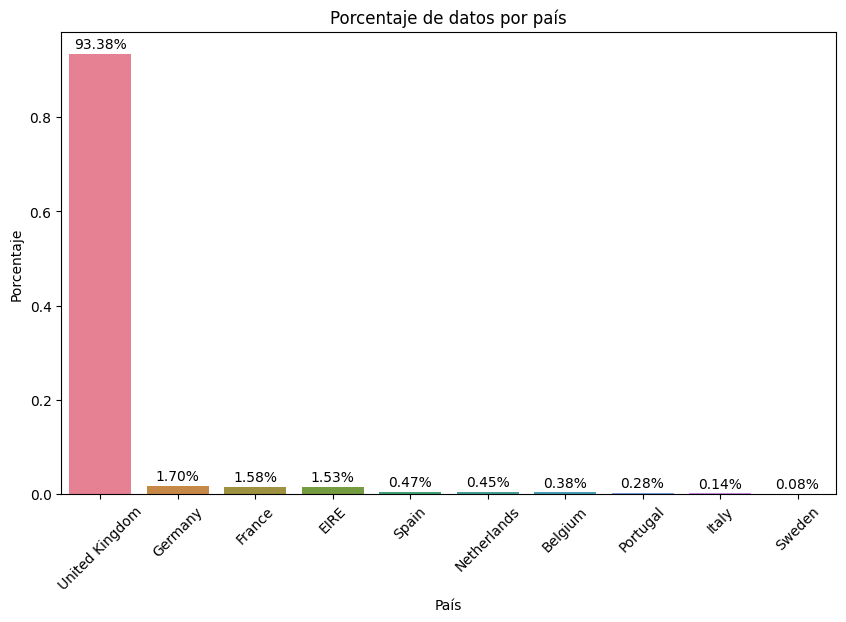

In [153]:
porcentaje_paises = df["Country"].value_counts(normalize=True).reset_index()
porcentaje_paises.columns = ['Country', 'Percentage']

paleta = sns.color_palette("husl", len(porcentaje_paises))

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=porcentaje_paises, x='Country', y='Percentage', palette=paleta)
plt.title('Porcentaje de datos por país')
plt.xlabel('País')
plt.ylabel('Porcentaje')
plt.xticks(rotation=45)

for i, percentage in enumerate(porcentaje_paises['Percentage']):
    barplot.text(i, percentage + 0.005, f'{percentage:.2%}', ha='center', va='bottom')

plt.show()

Vemos que Reino Unido acapara casi todo el porcentaje de observaciones. Más adelante se mostrará como se ha decidido tratar las distintas series temporales de los diferentes países.

Antes de graficar las series temporales, debemos tratar ciertos aspectos. 

Lo primero, vamos calcular el número de ventas diarias por país. 

In [154]:
# Agrupar y sumar las ventas totales diarias por país
df = df.groupby(['Date', 'Country'])['TotalSales'].sum().reset_index()
df.rename(columns={'TotalSales': 'DailySales'}, inplace=True)

# Ajustar el índice del DataFrame para que 'Date' sea el índice
df.set_index('Date', inplace=True)

# Mostrar el resultado
df.head(20)

,Country,DailySales
Date,,
2022-12-01,EIRE,433.0800
2022-12-01,France,738.9000
2022-12-01,Germany,243.4800
2022-12-01,Netherlands,177.6000
2022-12-01,United Kingdom,52323.1200
2022-12-02,EIRE,22.5000
2022-12-02,Germany,127.4000
2022-12-02,United Kingdom,46407.6400
2022-12-03,Belgium,268.9000


Si nos fijamos en como está estructurada la base de datos vemos que hay veces que algún país no tiene ninguna venta en un día en concreto, lo cuál provocaría saltos en el tiempo si representamos gráficamente la serie temporal. A su vez las conclusiones que obtendríamos en ciertos análisis, como por ejemplo las gráficas de Autocorrelación y Autocorrelación parcial no serían validad al no saber que saltos en el tiempo se han producido en cada serie de cada país.

Por lo tanto, para cada país en cada fecha desde la fecha incial hasta la fecha final, vamos a añadir un 0 en caso de que no se haya producido ninguna venta.

In [155]:
df_grouped = df.groupby(['Date', 'Country']).sum()

# Crear un rango de fechas
date_range = pd.date_range(start=df.index.min(), end=df.index.max())

# Obtener la lista única de países
countries = df['Country'].unique()

# Crear un MultiIndex con todas las combinaciones de fechas y países
multi_index = pd.MultiIndex.from_product([date_range, countries], names=['Date', 'Country'])

# Reindexar el DataFrame agrupado con el MultiIndex
df_full = df_grouped.reindex(multi_index, fill_value=0).reset_index()

In [156]:
df_full.head(30)

,Date,Country,DailySales
0,2022-12-01,EIRE,433.0800
1,2022-12-01,France,738.9000
2,2022-12-01,Germany,243.4800
3,2022-12-01,Netherlands,177.6000
4,2022-12-01,United Kingdom,52323.1200
5,2022-12-01,Belgium,0.0000
6,2022-12-01,Italy,0.0000
7,2022-12-01,Portugal,0.0000
8,2022-12-01,Spain,0.0000
9,2022-12-01,Sweden,0.0000


Ahora que ya hemos conseguido completar todos los valores faltantes que presentaba cada país para cada fecha, vamos a calcular el porcentaje de ceros que presenta cada país a lo largo de la serie.

In [157]:
# Agrupar los datos por país
grupo_pais = df_full.groupby('Country')

# Crear un diccionario para almacenar los porcentajes de valores iguales a 0
porcentaje_ceros = {}

# Calcular el porcentaje de valores iguales a 0 para cada grupo
for pais, data in grupo_pais:
    porcentaje_ceros[pais] = (data['DailySales'] == 0).mean() * 100

# Convertir el diccionario a un dataframe para una mejor visualización
result_df = pd.DataFrame.from_dict(porcentaje_ceros, orient='index', columns=['Porcentaje_Ceros'])

# Mostrar el resultado
print(result_df)

                Porcentaje_Ceros
Belgium                  77.8075
EIRE                     57.4866
France                   45.4545
Germany                  46.7914
Italy                    91.7112
Netherlands              83.6898
Portugal                 87.9679
Spain                    80.2139
Sweden                   91.4439
United Kingdom           18.4492


Debido a que todos los países menos United Kingdom tienen un alto porcentaje de ceros, creo conveniente agrupar los países sumando los valores de las ventas para cada fecha y de esta manera sacar conclusiones de ventas a nivel europeo y no diferenciando por país.

In [158]:
# Agrupar y sumar las ventas totales diarias sin diferenciar por país
df_agrupado = df_full.groupby('Date')['DailySales'].sum().reset_index()

# Ajustar el índice del DataFrame para que 'Date' sea el índice
df_agrupado.set_index('Date', inplace=True)

# Mostrar el resultado
df_agrupado.head()

,DailySales
Date,
2022-12-01,53916.1800
2022-12-02,46557.5400
2022-12-03,42929.8000
2022-12-04,0.0000
2022-12-05,28376.6600


Una vez limpia la base de datos, representamos gráficamente la serie de ventas a nivel europeo

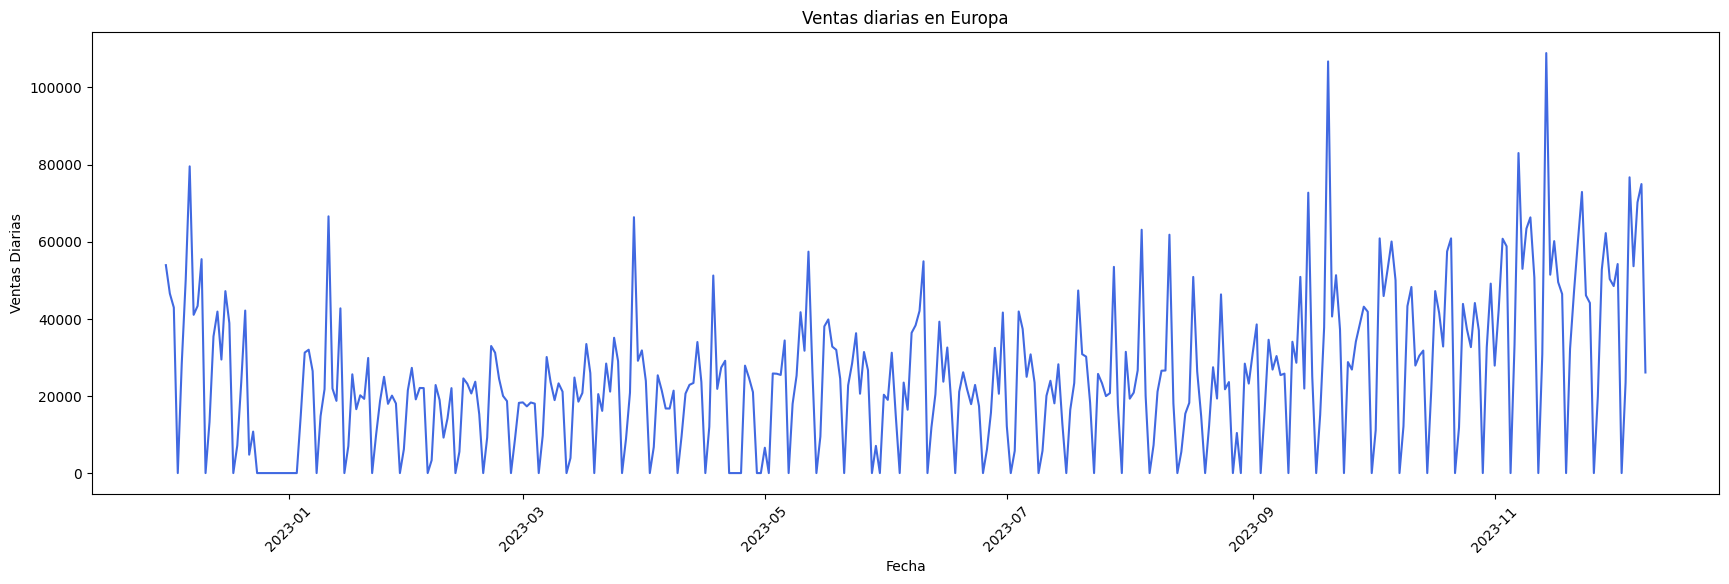

In [159]:
# Graficar usando Seaborn
plt.figure(figsize=(21, 6))
sns.lineplot(data=df_agrupado, x=df_agrupado.index, y='DailySales', color='#4169E1')
plt.title('Ventas diarias en Europa')
plt.xlabel('Fecha')
plt.ylabel('Ventas Diarias')
plt.xticks(rotation=45)
plt.show()

Una vez limpios los datos, comenzamos con la construcción de distintos modelos de predicción.

<a id='seccion3'></a>
## 3. Modelo SARIMAX - Análisis de los componentes de la serie

Realizamos la descomposición de la serie para poder ajustar la serie temporal bajo un modelo SARIMAX, ya que este modelo tiene la siguiente estructura: (p,d,q)(P,D,Q,s), y necesitamos conocer sus parámetros

Antes de poder analizar los distintos componentes de una serie temporal, hay que decidir si vamos a emplear un Modelo Aditivo o un Modelo Multiplicativo.

Para tomar esa decisión, hay que fijarse en la amplitud de la serie a lo largo del tiempo. Si esta amplitud es constante es más preciso emplear un modelo aditivo. 

El otro aspecto a analizar a priori, es la tendencia de la serie, que de ser exponencial, sería más conveniente utilizar un modelo multiplicativo al capturar este mejor la tendencia exponencial de una serie de tiempo.

Por tanto, si observamos la amplitud de las distintas series de tiempo vemos que es constante, exeptuando algunos momentos puntuales. A su vez vemos que ninguna serie presenta a priori tendencia exponencial. Por ello, vamos a emplear el **Modelo Aditivo**

Un modelo aditivo es lineal, y está formulado bajo la siguiente ecuación:  $y(t) = Estacionariedad + Tendencia + Estacionalidad + Ruido$

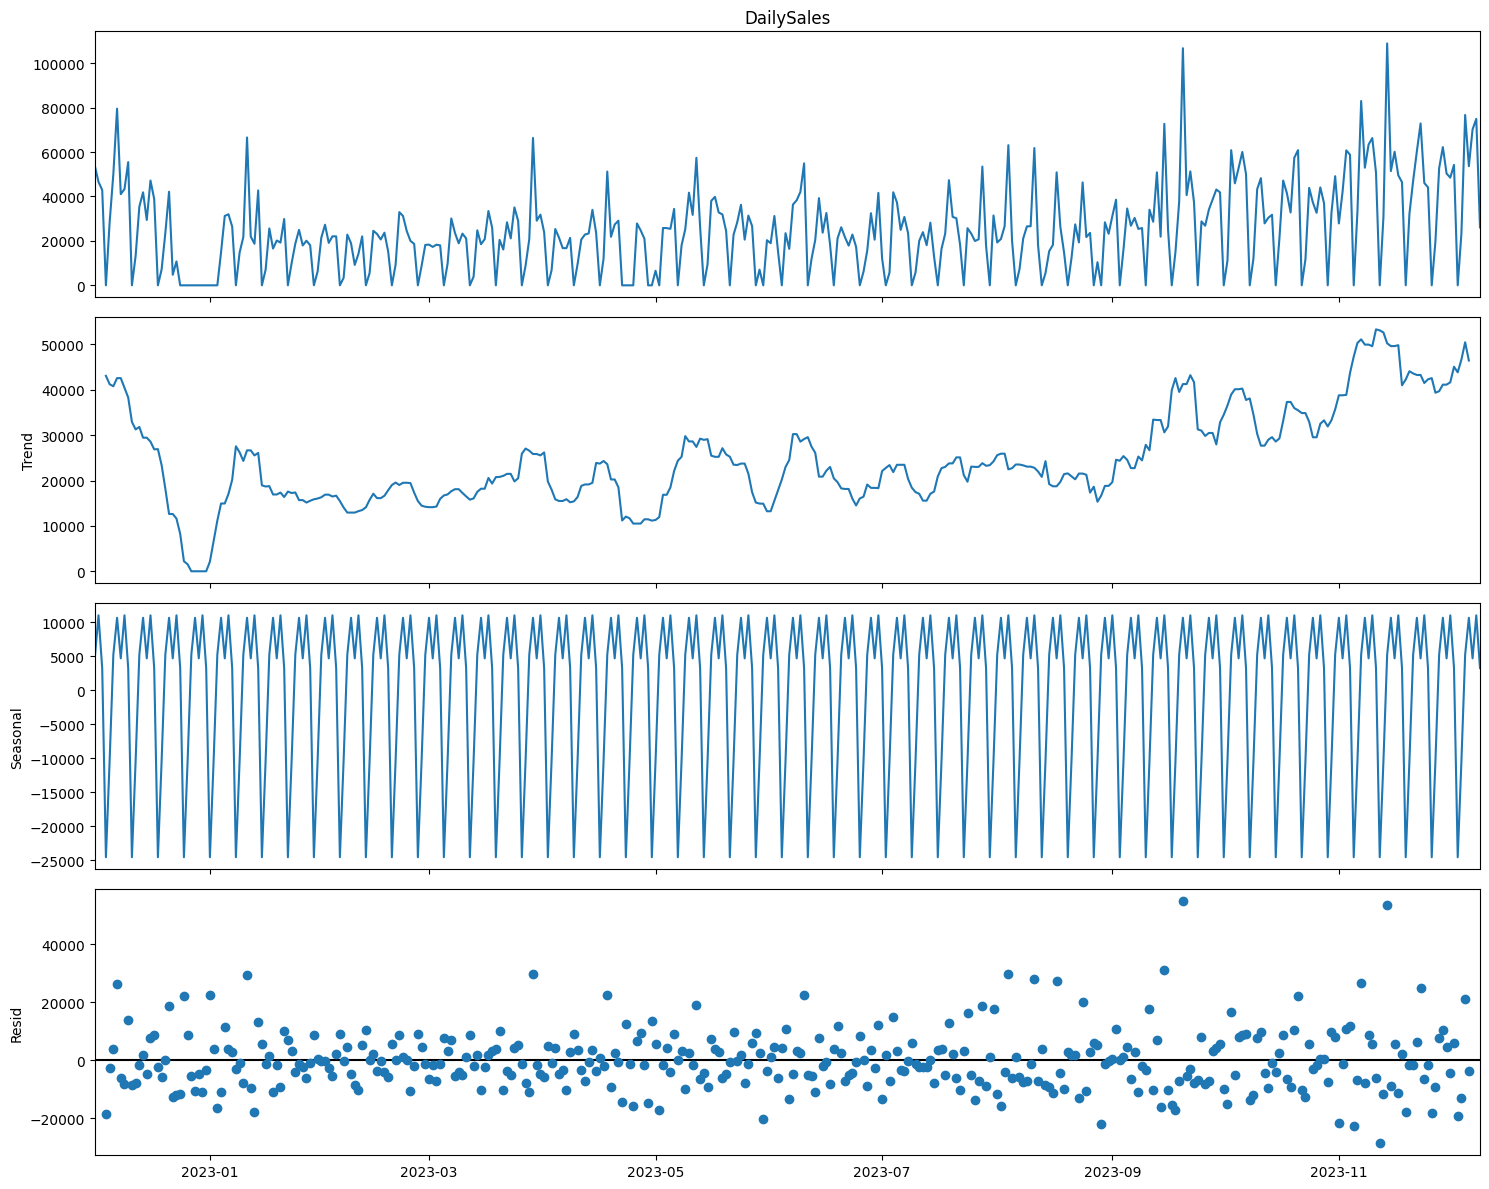

In [160]:
result = seasonal_decompose(df_agrupado['DailySales'], model ='additive', period = 7)

result.plot()
plt.show()

### 3.1 Estacionariedad

Para estudiar la estacionariedad de la serie temporal, necesitamos calcular el estadístico de Dickey-Fuller y su correspondiente p_valor. 

El test de Dickey-Fuller se utiliza para verificar la presencia de una raíz unitaria en una serie temporal, es decir, para determinar si una serie temporal es estacionaria o no. Las hipótesis del test son las siguientes:

- **Hipótesis nula (H₀):** La serie temporal tiene una raíz unitaria, lo que implica que la serie no es estacionaria.
- **Hipótesis alternativa (H₁):** La serie temporal no tiene una raíz unitaria, lo que implica que la serie es estacionaria.

$
H_0: \phi = 1
$

$
H_1: \phi < 1
$


In [161]:
dkfuller = adfuller(df_agrupado['DailySales'])
print('Estadístico Dickey-Fuller:', dkfuller[0])
print('p_valor:', dkfuller[1])


Estadístico Dickey-Fuller: -1.7070544435846609
p_valor: 0.4274815296408319


Si obtenemos un estadístico cuyo p_valor asociado es inferior a 0.05, podemos decir que existe suficiente evidencia estadística para rechazar H₀. Por tanto aquella serie que presente un p_valor asociado <0.05 será estacionaria, en caso contrario, si la serie presenta un p_valor superior a 0.05, estaría indicando que la serie no es estacionaria.

Como vemos, la serie presenta un p_valor superior a 0.05, por lo tanto no es estacionaria.

Vamos a aplicarle una diferenciación a la serie Reino Unido para convertirla en estacionaria

In [162]:
df_agrupado['DailySales_Diff'] = df_agrupado['DailySales'].diff()

In [163]:
df_agrupado

,DailySales,DailySales_Diff
Date,,
2022-12-01,53916.1800,NaN
2022-12-02,46557.5400,-7358.6400
2022-12-03,42929.8000,-3627.7400
2022-12-04,0.0000,-42929.8000
2022-12-05,28376.6600,28376.6600
...,...,...
2023-12-05,76692.1100,53195.8700
2023-12-06,53636.6000,-23055.5100
2023-12-07,70196.8300,16560.2300


Una vez aplicada la difernciación, comprobamos si ya la hemos convertido en estacionaria

In [164]:
dkfuller = adfuller(df_agrupado['DailySales_Diff'].dropna())
print('Estadístico Dickey-Fuller:', dkfuller[0])
print('p_valor:', dkfuller[1])

Estadístico Dickey-Fuller: -8.358353161638382
p_valor: 2.8681601969498424e-13


Ahora si que hemos conseguido una serie estandarizada. Vemos su representación gráfica para ver cómo queda.

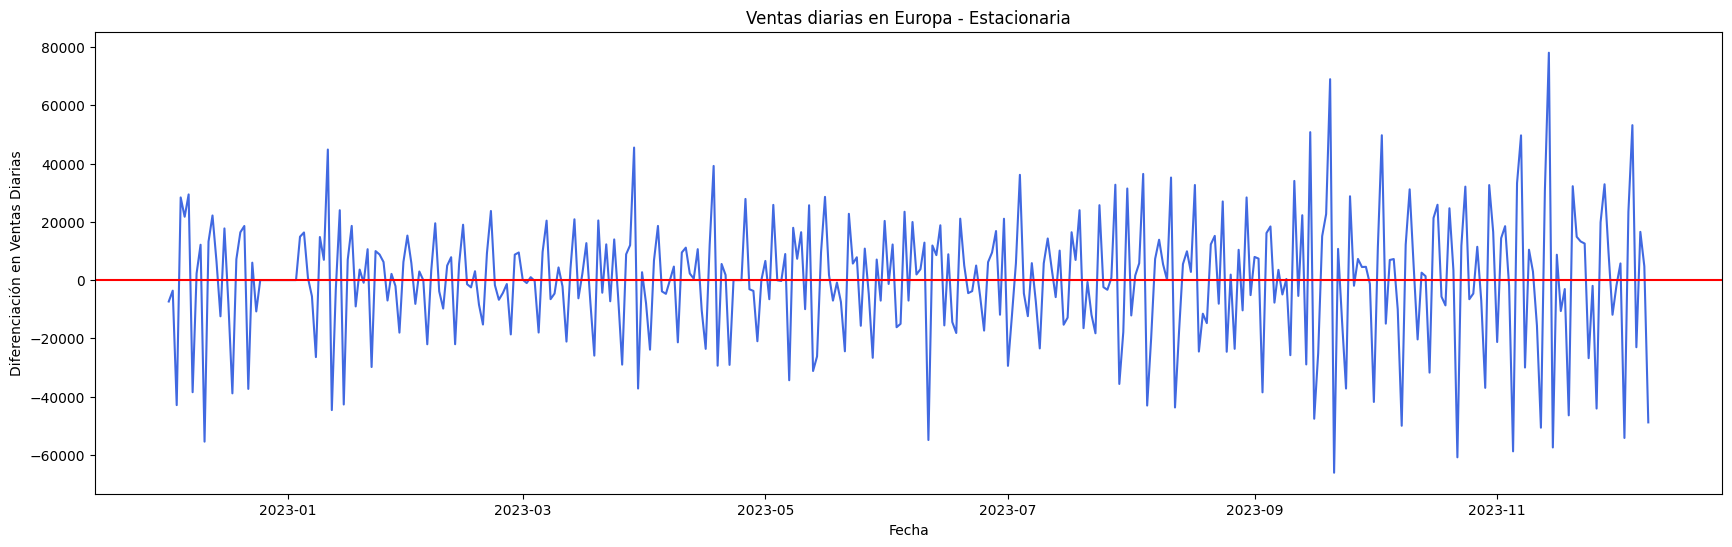

In [165]:
# Crear la figura y el eje
plt.figure(figsize=(21, 6))

# Dibujar la línea de ventas diarias en Reino Unido
sns.lineplot(data=df_agrupado, x=df_agrupado.index, y='DailySales_Diff', color='#4169E1')

# Configurar el título y las etiquetas
plt.title('Ventas diarias en Europa - Estacionaria')
plt.xlabel('Fecha')
plt.ylabel('Diferenciación en Ventas Diarias')
plt.axhline(y=0, color='red')
# Mostrar la figura
plt.show()

Como vemos hemos logrado que la serie sea estacionaria

Pasamos por tanto a estudiar la **Autocorrelación** y **Autocorrelación Parcial** de la serie

### 3.2 Autocorrelación y Autocorrelación Parcial

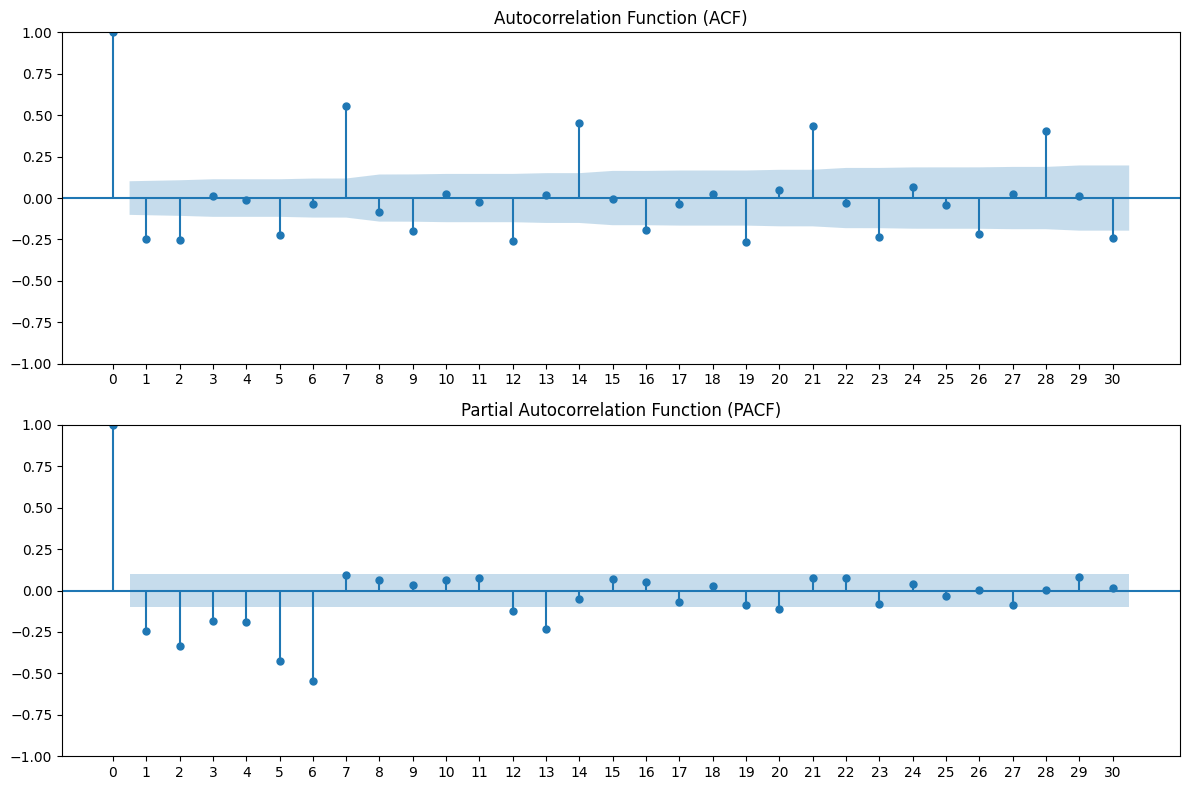

In [166]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Gráfico de autocorrelación (ACF)
plot_acf(df_agrupado['DailySales_Diff'].dropna(), lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
ax[0].set_xticks(range(0, 31, 1))  # Ajustar el eje x para mostrar todos los valores de lag

# Gráfico de autocorrelación parcial (PACF)
plot_pacf(df_agrupado['DailySales_Diff'].dropna(), lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
ax[1].set_xticks(range(0, 31, 1))  # Ajustar el eje x para mostrar todos los valores de lag

plt.tight_layout()
plt.show()

Dado que el parámetro *q* de un modelo ARIMA es el orden del componente de media móvil (MA) y está basado en el gráfico ACF, por tanto, a priori, en nuestro modelo el parámetro *q* tendrá el valor de 7

Y a su vez, el parámetro *p* de un modelo ARIMA es el orden del componente autoregresivo (AR) y está basado en el gráfico PACF, por tanto, a priori, en nuestro modelo el parámetro *p* tendrá el valor de 6

### 3.3 Estacionalidad 

Cómo habiamos visto en el gráfico de Autocorrelación, el periodo de estacionalidad de esta serie era de 7 días.

In [167]:
df_agrupado['Seasonal_Diff'] = df_agrupado['DailySales'] - df_agrupado['DailySales'].shift(7)
df_agrupado

,DailySales,DailySales_Diff,Seasonal_Diff
Date,,,
2022-12-01,53916.1800,NaN,NaN
2022-12-02,46557.5400,-7358.6400,NaN
2022-12-03,42929.8000,-3627.7400,NaN
2022-12-04,0.0000,-42929.8000,NaN
2022-12-05,28376.6600,28376.6600,NaN
...,...,...,...
2023-12-05,76692.1100,53195.8700,23938.8000
2023-12-06,53636.6000,-23055.5100,-8587.8600
2023-12-07,70196.8300,16560.2300,19876.0700


In [168]:
dkfuller = adfuller(df_agrupado['Seasonal_Diff'].dropna())
print('Estadístico Dickey-Fuller:', dkfuller[0])
print('p_valor:', dkfuller[1])

Estadístico Dickey-Fuller: -6.397484546228532
p_valor: 2.033834261808298e-08


Calculamos de nuevo los gráficos de ACF y PACF para la serie estacional diferenciada

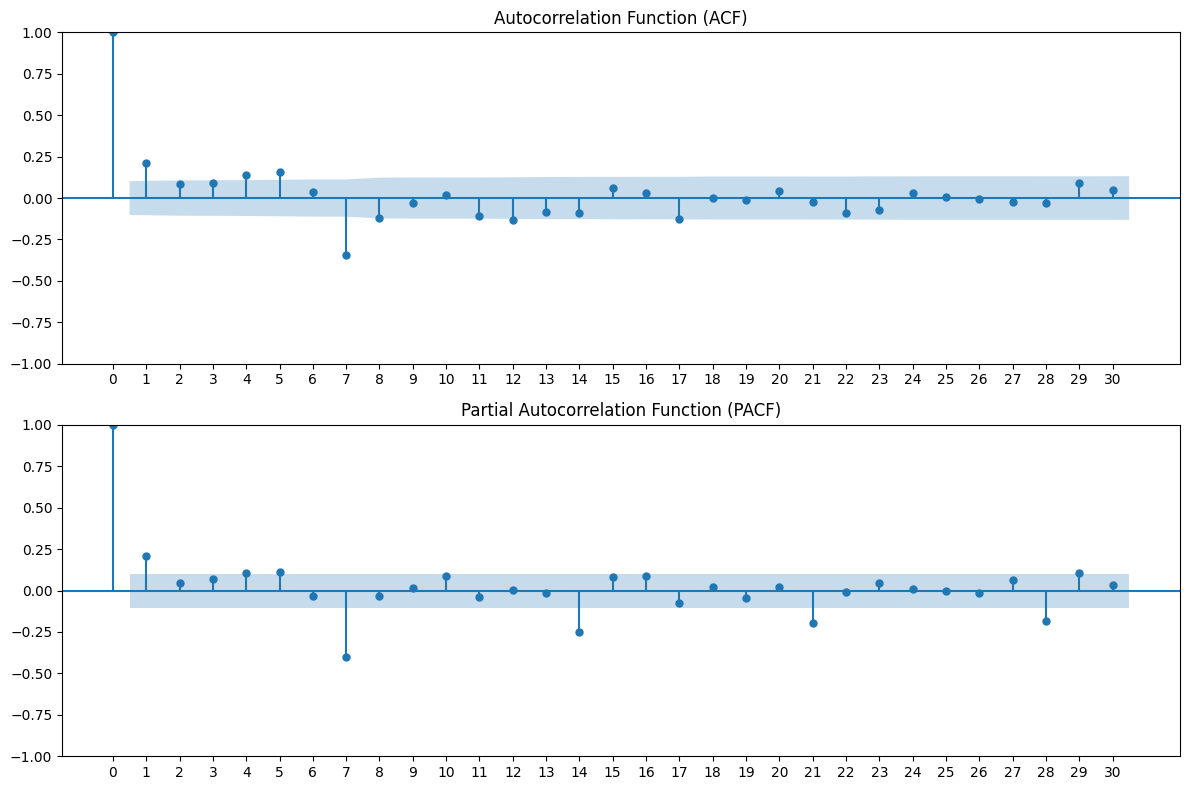

In [169]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Gráfico de autocorrelación (ACF)
plot_acf(df_agrupado['Seasonal_Diff'].dropna(), lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
ax[0].set_xticks(range(0, 31, 1))  # Ajustar el eje x para mostrar todos los valores de lag

# Gráfico de autocorrelación parcial (PACF)
plot_pacf(df_agrupado['Seasonal_Diff'].dropna(), lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
ax[1].set_xticks(range(0, 31, 1))  # Ajustar el eje x para mostrar todos los valores de lag

plt.tight_layout()
plt.show()

Vemos que son significativos los retardos 7 para ambas gráficas, luego la estacionalidad está clara

### 3.4 Auto-ARIMA

Utilizo el modelo AutoArima para buscar los parámetros óptimos para *p*,*q*,*P*,*Q*, ya que si conocemos los valores de *s*, *d* y *D*

In [170]:
modelo_auto_arima = auto_arima(df_agrupado['DailySales'],
                       start_P=0,
                       max_P=20,
                       start_Q=0,
                       max_Q=20,
                       max_p=20,
                       start_p=20,
                       start_q=0,
                       max_q=20,
                       m=7,
                       seasonal=True,
                       D=0,
                       d=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
modelo_auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(6,1,0)(0,0,0)[7] intercept   : AIC=8194.156, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8490.557, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8337.329, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8264.485, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8488.563, Time=0.01 sec
 ARIMA(6,1,0)(1,0,0)[7] intercept   : AIC=8177.585, Time=2.30 sec
 ARIMA(6,1,0)(2,0,0)[7] intercept   : AIC=8196.021, Time=1.71 sec
 ARIMA(6,1,0)(1,0,1)[7] intercept   : AIC=8133.892, Time=2.37 sec
 ARIMA(6,1,0)(0,0,1)[7] intercept   : AIC=8154.461, Time=3.00 sec
 ARIMA(6,1,0)(2,0,1)[7] intercept   : AIC=8135.026, Time=3.06 sec
 ARIMA(6,1,0)(1,0,2)[7] intercept   : AIC=8134.947, Time=3.60 sec
 ARIMA(6,1,0)(0,0,2)[7] intercept   : AIC=8152.516, Time=3.45 sec
 ARIMA(6,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=4.82 sec
 ARIMA(5,1,0)(1,0,1)[7] intercept   : AIC=8181.119, Time=2.11 sec
 ARIMA(6,1,1)(1,0,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  374
Model:             SARIMAX(6, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -4056.106
Date:                             Sun, 28 Jul 2024   AIC                           8130.213
Time:                                     12:36:20   BIC                           8165.507
Sample:                                 12-01-2022   HQIC                          8144.228
                                      - 12-09-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7808      0.061    -12.792      0.000      -0.900      -0.661
ar.L2         -0.6655      0.079     -8.396      0.000      -0.821      -0.510
ar.L3         -0.5117      0.084     -6.114      0.000      -0.676      -0.348
ar.L4         -0.3551      0.076     -4.692      0.000      -0.503      -0.207
ar.L5         -0.2365      0.077     -3.084      0.002      -0.387      -0.086
ar.L6         -0.1485      0.056     -2.631      0.009      -0.259      -0.038
ar.S.L7        0.9935      0.007    144.538      0.000       0.980       1.007
ma.S.L7       -0.8972      0.046    -19.606      0.000      -0.987      -0.807
sigma2      1.822e+08   3.02e-10   6.04e+17      0.000    1.82e+08    1.82e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               236.12
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+33. Standard errors may be unstable.
"""

### 3.5 Modelización y predicciones

In [171]:
model = SARIMAX(df_agrupado['DailySales'], 
                order=(6, 1, 0), 
                seasonal_order=(1, 0, 1, 7))
results = model.fit()

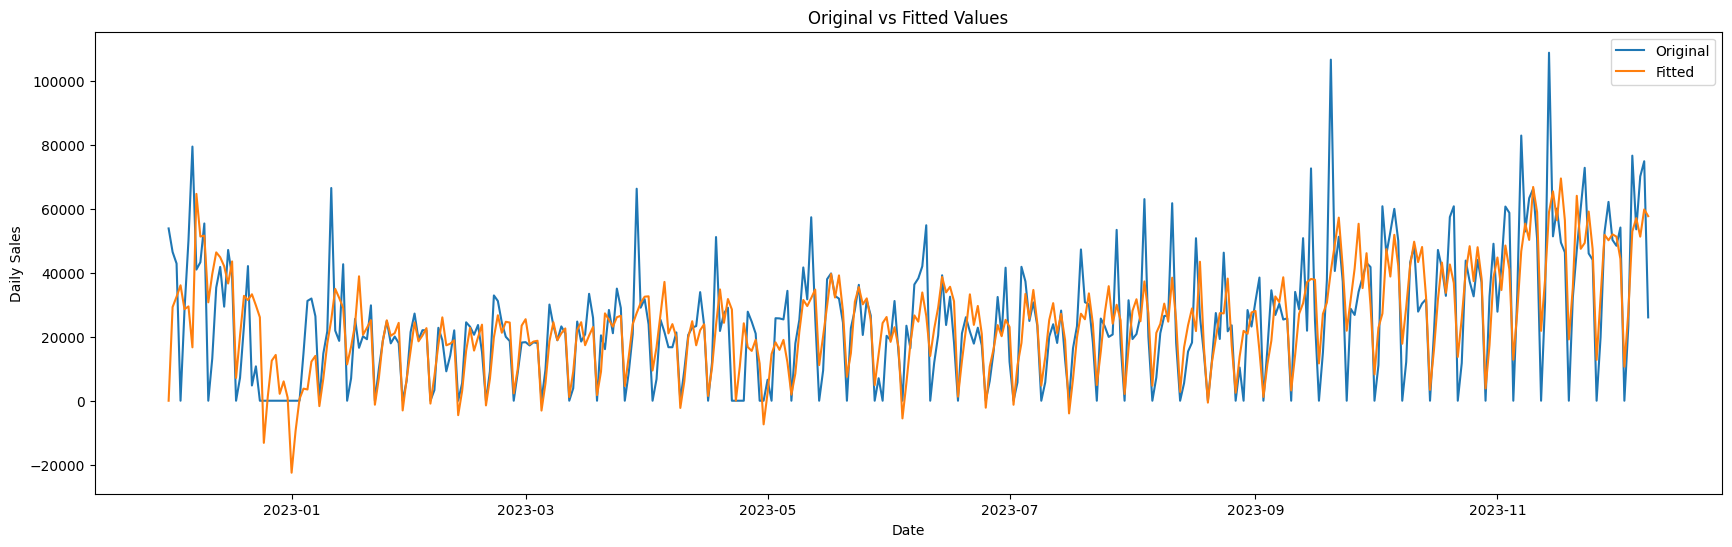

In [172]:
df_agrupado['Fitted'] = results.fittedvalues

# Graficar la serie original y las predicciones
plt.figure(figsize=(21, 6))
plt.plot(df_agrupado['DailySales'], label='Original')
plt.plot(df_agrupado['Fitted'], label='Fitted')
plt.legend()
plt.title('Original vs Fitted Values')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.show()

Calculamos el RMSE y R2 score para ver como fitea el modelo

In [173]:
df_agrupado['DailySales'].mean()

24862.142005347592

In [174]:
root_mean_squared_error(y_pred = df_agrupado['Fitted'], y_true = df_agrupado['DailySales'])

13196.334864071814

In [175]:
r2_score(y_pred = df_agrupado['Fitted'], y_true = df_agrupado['DailySales'])

0.5329294761899857

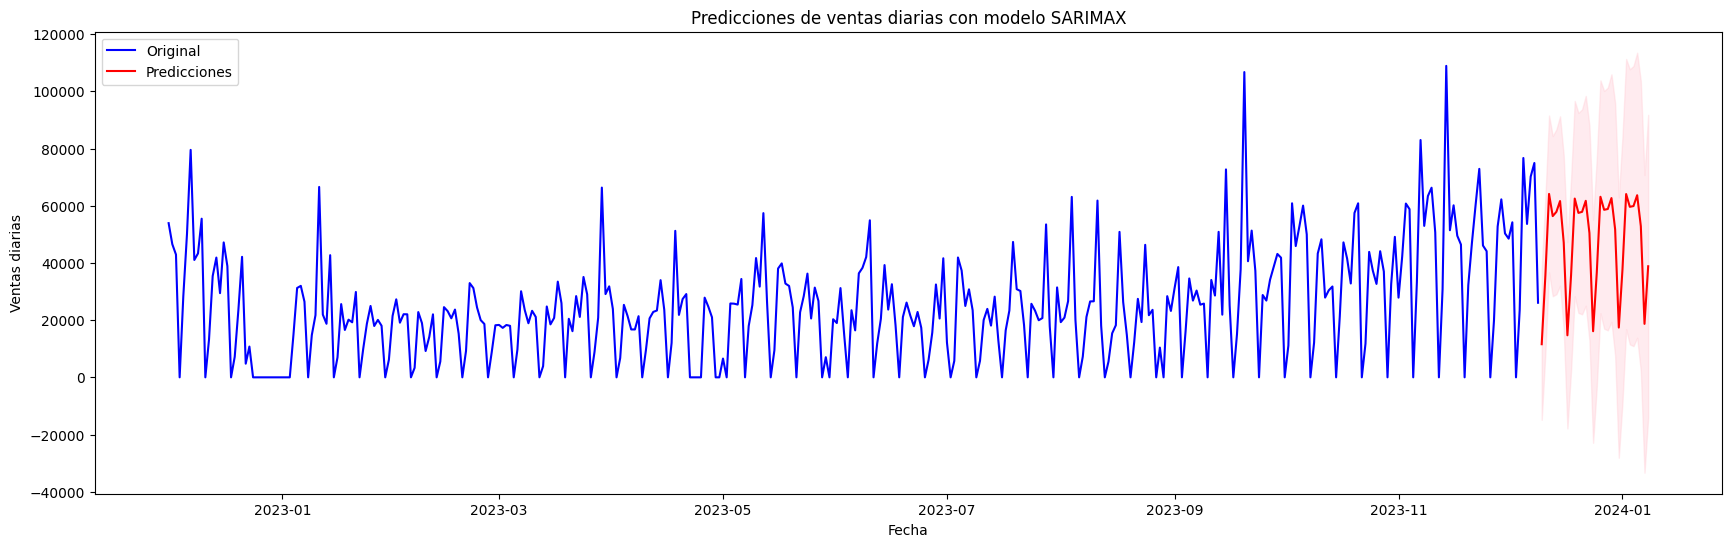

In [176]:
# Establecer el número de pasos de la predicción
forecast_steps = 30
forecast = results.get_forecast(steps=forecast_steps)

# Obtener los valores predichos y los intervalos de confianza
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Crear un rango de fechas para los valores predichos (desde el día siguiente al último día en los datos originales)
forecast_index = pd.date_range(start=df_agrupado.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Crear una figura para graficar
plt.figure(figsize=(21, 6))

# Graficar la serie original
plt.plot(df_agrupado.index, df_agrupado['DailySales'], label='Original', color='blue')

# Graficar las predicciones
plt.plot(forecast_index, forecast_values, label='Predicciones', color='red')

# Rellenar el área entre los intervalos de confianza
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Ventas diarias')
plt.title('Predicciones de ventas diarias con modelo SARIMAX')
plt.legend()

# Mostrar la gráfica
plt.show()

El modelo es capaz de seguir la tendencia general de manera moderada y los patrones estacionales hasta cierto punto, pero hay margen de mejora, por tanto vamos a pasar al modelo Prophet ya que este tiene la capacidad de manejar de manera automática, sencilla y robusta los componentes de tendencia y estacionalidad.

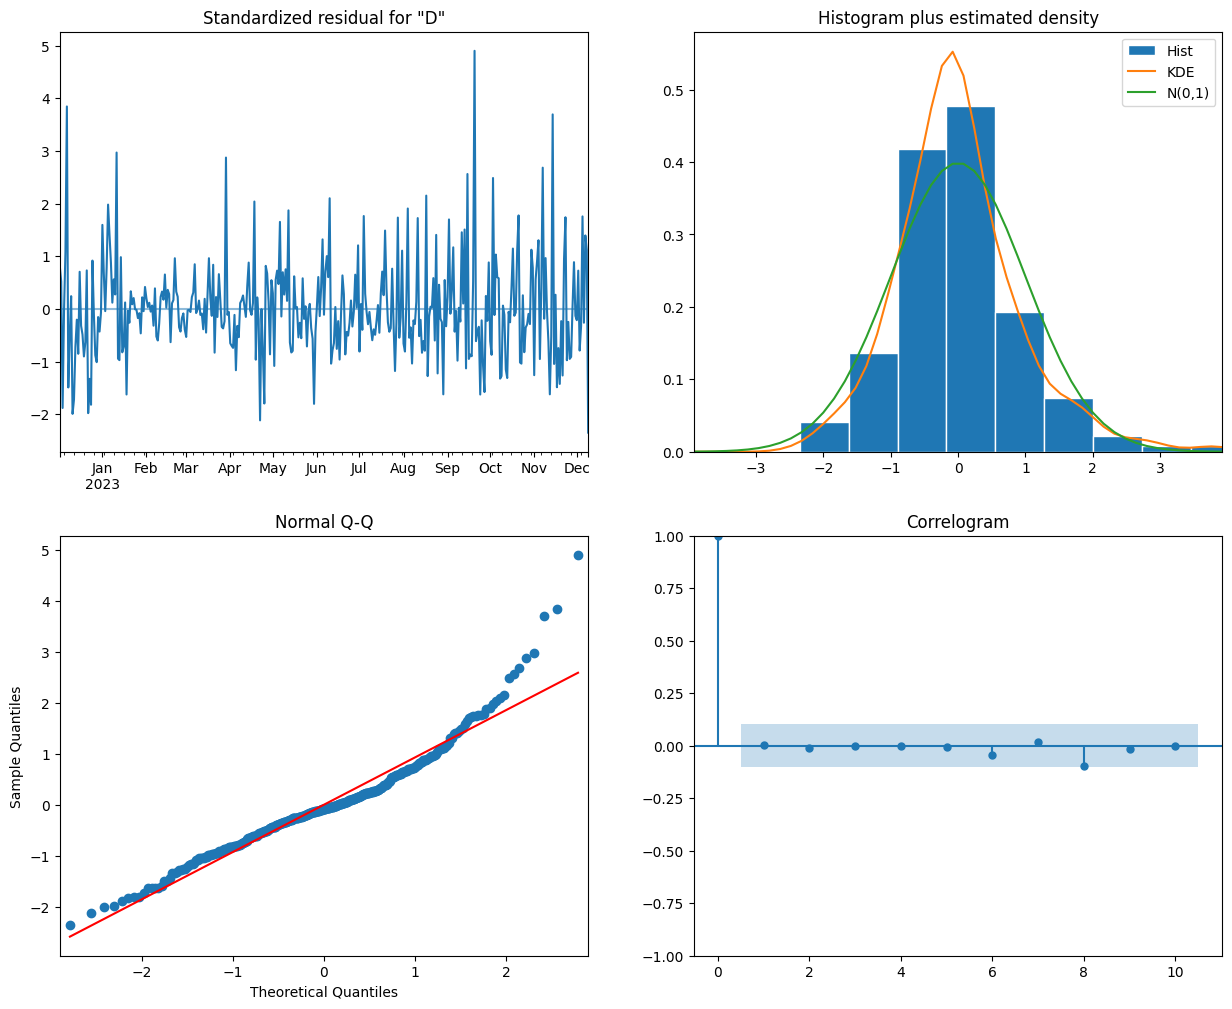

In [177]:
diag = results.plot_diagnostics()

El primer gráfico (arriba izquierda) nos muestra los residuos estandarizados del modelo SARIMAX a lo largo del tiempo. Un buen modelo debería tener residuos que se distribuyan aleatoriamente alrededor de cero, sin patrones evidentes. En este caso, los residuos parecen bastante aleatorios, aunque hay algunos picos que podrían indicar eventos no capturados por el modelo.

En el segundo gráfico (arriba derecha) se histograma de los residuos estandarizados se superpone con una curva de densidad estimada (KDE) y una distribución normal N(0,1). Un buen ajuste se observaría si el histograma y la curva KDE se alinean bien con la curva de la distribución normal. Aquí, aunque la distribución de los residuos no se desvía severamente de la normal, hay algunas discrepancias, especialmente en los extremos, sugiriendo posibles colas pesadas.

El gráfico Q-Q (inferior izquierdo) compara los cuantiles de los residuos estandarizados con los cuantiles de una distribución normal. Si los residuos siguen una distribución normal, los puntos deberían alinearse aproximadamente con la línea roja (que representa la distribución normal). En este gráfico, hay una desviación significativa en los cuantiles extremos, indicando que los residuos no son perfectamente normales, mostrando algunos residuos valores extremos mayores a los esperados.

El correlograma (inferior derecha) muestra las autocorrelaciones de los residuos para diferentes retardos. Las barras deben estar dentro de la banda de confianza (en azul claro) para indicar que no hay autocorrelación significativa. En este caso, parece que las autocorrelaciones están dentro de los límites de confianza, lo que sugiere que los residuos no presentan autocorrelación significativa, una señal de que el modelo ha capturado bien las dependencias temporales.

<a id='seccion4'></a>
## 4. Prophet

In [178]:
df_agrupado = df_agrupado.reset_index()
df_agrupado

,Date,DailySales,DailySales_Diff,Seasonal_Diff,Fitted
0,2022-12-01,53916.1800,NaN,NaN,0.0000
1,2022-12-02,46557.5400,-7358.6400,NaN,29303.5209
2,2022-12-03,42929.8000,-3627.7400,NaN,32548.2437
3,2022-12-04,0.0000,-42929.8000,NaN,36127.7606
4,2022-12-05,28376.6600,28376.6600,NaN,28645.2552
...,...,...,...,...,...
369,2023-12-05,76692.1100,53195.8700,23938.8000,52961.0962
370,2023-12-06,53636.6000,-23055.5100,-8587.8600,57145.3037
371,2023-12-07,70196.8300,16560.2300,19876.0700,51341.5352
372,2023-12-08,74938.8800,4742.0500,26449.4700,59860.1629


Dado que United Kingdom suponía el 93% de los datos de la serie, solo vamos a tener en cuenta las vacaciones de este país.

In [179]:
holidays_custom = pd.DataFrame({
    'holiday': 'close',
    'ds': pd.to_datetime(['2022-12-24','2022-12-25','2022-12-26',
                        '2022-12-27', '2022-12-28', '2022-12-29',
                        '2022-12-30', '2022-12-31', '2023-01-01',
                        '2023-01-02', '2023-01-02', '2023-01-03',
                        '2023-04-22', '2023-04-23','2023-04-24',
                        '2023-04-25', '2023-12-24','2023-12-25',
                        '2023-12-26', '2023-12-27', '2023-12-28', 
                        '2023-12-29', '2023-12-30', '2023-12-31',
                        '2023-01-01', '2023-01-02', '2023-01-02', 
                        '2023-01-03']),
    'lower_window': 0,#siempre va con estos valores
    'upper_window': 1,
})

12:36:27 - cmdstanpy - INFO - Chain [1] start processing
12:36:27 - cmdstanpy - INFO - Chain [1] done processing


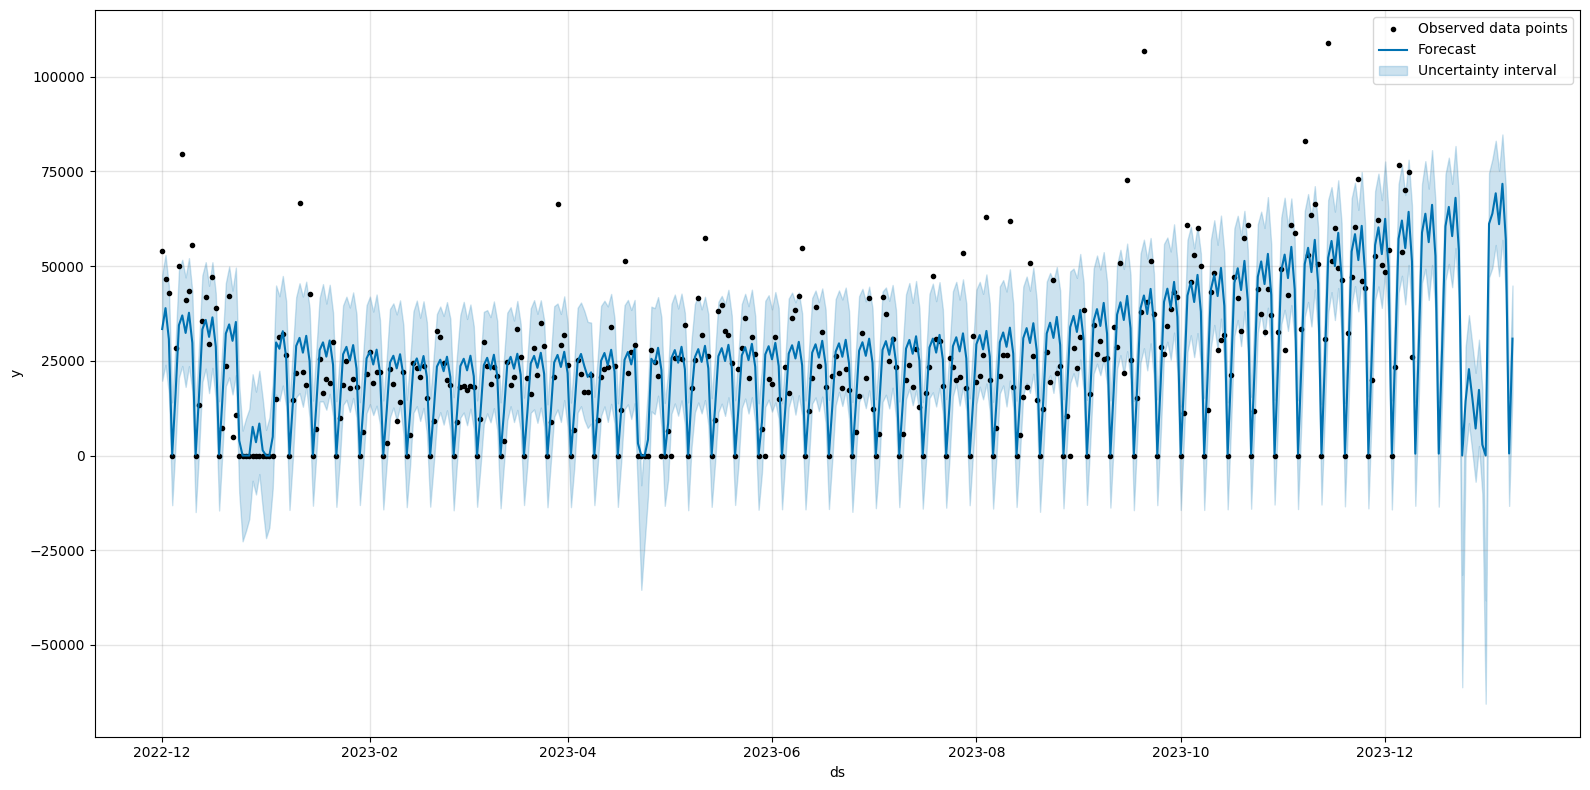

In [180]:
df_prophet = df_agrupado[['Date', 'DailySales']]
df_prophet.columns = ['ds', 'y']

# Creación y ajuste del modelo Prophet
model = Prophet(holidays=holidays_custom, seasonality_mode='multiplicative', weekly_seasonality=True).add_country_holidays(country_name='UK')
model.fit(df_prophet)

# Creación de un DataFrame para hacer predicciones (por ejemplo, para los próximos 365 días)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(0, x))

fig = model.plot(forecast,include_legend=True,figsize=(16, 8))

In [181]:
# Creación de un DataFrame para hacer predicciones para toda la serie
future = model.make_future_dataframe(periods=0)  # Sin periodos futuros, solo los datos históricos
forecast = model.predict(future)

# Filtrar las predicciones para el periodo original
forecast_original = forecast[['ds', 'yhat']]

# Calcular RMSE y R²
rmse = np.sqrt(mean_squared_error(df_prophet['y'], forecast_original['yhat']))
r2 = r2_score(df_prophet['y'], forecast_original['yhat'])

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

RMSE: 11020.311455411507
R²: 0.6742656621623682


Vemos que el R CUadrado de este modelo ha mejorado en un 14% frente al SARIMAX, luego es una notable mejora.

<a id='seccion5'></a>
## 5. XGBoost

Vamos a pasar al último modelo que vamos a utilizar.

In [182]:
df_agrupado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             374 non-null    datetime64[ns]
 1   DailySales       374 non-null    float64       
 2   DailySales_Diff  373 non-null    float64       
 3   Seasonal_Diff    367 non-null    float64       
 4   Fitted           374 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 14.7 KB


Debemos de quitar primero todas las variables que no podamos usar para predecir a futuro, al no tener valores para esas variables en las fechas futuras.

In [183]:
df_agrupado = df_agrupado.drop(columns=['Fitted',"Seasonal_Diff","DailySales_Diff"])

In [184]:
df_agrupado

,Date,DailySales
0,2022-12-01,53916.1800
1,2022-12-02,46557.5400
2,2022-12-03,42929.8000
3,2022-12-04,0.0000
4,2022-12-05,28376.6600
...,...,...
369,2023-12-05,76692.1100
370,2023-12-06,53636.6000
371,2023-12-07,70196.8300
372,2023-12-08,74938.8800


Creamos nuevas variables con los propios datos de la serie | **Feature Engineering**

In [185]:
# Convertir el índice a datetime
df_agrupado.set_index('Date', inplace=True)

# Crear columnas de año y mes
df_agrupado['Year'] = df_agrupado.index.year
df_agrupado['Month'] = df_agrupado.index.month
df_agrupado['DayOfWeek'] = df_agrupado.index.dayofweek
df_agrupado['DayOfYear'] = df_agrupado.index.dayofyear
df_agrupado['Quarter'] = df_agrupado.index.quarter
df_agrupado['IsWeekend'] = df_agrupado.index.dayofweek >= 5
df_agrupado['MA7'] = df_agrupado['DailySales'].rolling(window=7).mean()

# Crear columna lag de 1 y 7 días
df_agrupado['Lag1'] = df_agrupado['DailySales'].shift(1)
df_agrupado['Lag7'] = df_agrupado['DailySales'].shift(7)

# Llenar valores faltantes generados por las operaciones anteriores
df_agrupado = df_agrupado.fillna(0)

# Reemplazar valores infinitos y extremadamente grandes
df_agrupado.replace([np.inf, -np.inf], np.nan, inplace=True)
df_agrupado.fillna(0, inplace=True)

Aqui tenemos la nueva base de datos con todas las variables que vamos a utilizar en el modelo.

In [186]:
df_agrupado

,DailySales,Year,Month,DayOfWeek,DayOfYear,Quarter,IsWeekend,MA7,Lag1,Lag7
Date,,,,,,,,,,
2022-12-01,53916.1800,2022,12,3,335,4,False,0.0000,0.0000,0.0000
2022-12-02,46557.5400,2022,12,4,336,4,False,0.0000,53916.1800,0.0000
2022-12-03,42929.8000,2022,12,5,337,4,True,0.0000,46557.5400,0.0000
2022-12-04,0.0000,2022,12,6,338,4,True,0.0000,42929.8000,0.0000
2022-12-05,28376.6600,2022,12,0,339,4,False,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...
2023-12-05,76692.1100,2023,12,1,339,4,False,45061.0671,23496.2400,52753.3100
2023-12-06,53636.6000,2023,12,2,340,4,False,43834.2300,76692.1100,62224.4600
2023-12-07,70196.8300,2023,12,3,341,4,False,46673.6686,53636.6000,50320.7600


En estos modelos es muy recomendable dividir los datos en train y test para la propia construcción del modelo

In [187]:
# Dividir los datos en train y test (80% train, 20% test)
train_df, test_df = train_test_split(df_agrupado, test_size=0.2, shuffle=False)

# Separar las características (X) de la variable objetivo (y)
X_train = train_df.drop(columns=['DailySales'])
y_train = train_df['DailySales']
X_test = test_df.drop(columns=['DailySales'])
y_test = test_df['DailySales']

# Mostrar las dimensiones de los conjuntos de entrenamiento y prueba
print(f'Tamaño del conjunto de entrenamiento: {len(train_df)}')
print(f'Tamaño del conjunto de prueba: {len(test_df)}')

Tamaño del conjunto de entrenamiento: 299
Tamaño del conjunto de prueba: 75


Imprimimos ambos ficheros en una gráfica con dos colores

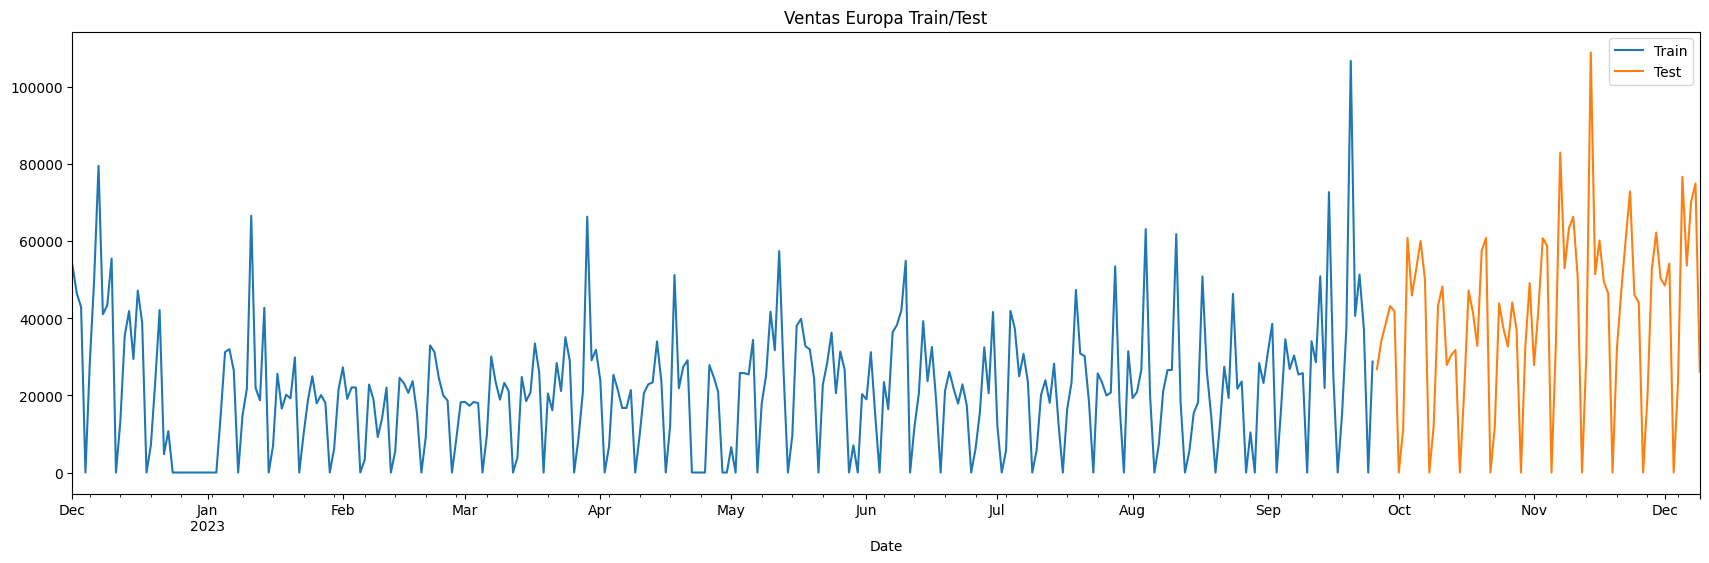

In [188]:
fig, ax = plt.subplots(figsize= (21,6), )
y_train.plot(ax = ax , label = "Train")
y_test.plot(ax = ax , label = "Test")
ax.legend(["Train", "Test"])
plt.title("Ventas Europa Train/Test")
plt.show()

Construimos un primer modelo con parámetros fijos

In [189]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1300, learning_rate=0.01, early_stopping_rounds = 50)
xgb_model.fit(X_train, y_train,
            eval_set = [(X_train,y_train),(X_test,y_test)],
            verbose= 100)

[0]	validation_0-rmse:16124.56041	validation_1-rmse:29491.44244
[100]	validation_0-rmse:9163.69006	validation_1-rmse:18077.57774
[200]	validation_0-rmse:6388.66412	validation_1-rmse:15538.61331
[300]	validation_0-rmse:4845.46631	validation_1-rmse:15439.87285
[309]	validation_0-rmse:4756.38398	validation_1-rmse:15468.51577


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [190]:
# Predicciones para el conjunto de entrenamiento y prueba
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

y_train_pred = pd.DataFrame(y_train_pred, columns=['xgb_predictions_train'],index= X_train.index)
y_test_pred = pd.DataFrame(y_test_pred, columns=['xgb_predictions_test'], index= X_test.index)

# Cálculo del RMSE para el conjunto de entrenamiento
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
# Cálculo del R² para el conjunto de entrenamiento
r2_train = r2_score(y_train, y_train_pred)

# Cálculo del RMSE para el conjunto de prueba
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
# Cálculo del R² para el conjunto de prueba
r2_test = r2_score(y_test, y_test_pred)

print(f'Train RMSE: {rmse_train}')
print(f'Train R²: {r2_train}')
print(f'Test RMSE: {rmse_test}')
print(f'Test R²: {r2_test}')

Train RMSE: 5346.017806354104
Train R²: 0.8916429122861783
Test RMSE: 15333.583024535697
Test R²: 0.5439764314630531


El modelo muestra un buen ajuste en el conjunto de entrenamiento pero presenta una notable disminución en el desempeño en el conjunto de prueba, lo cual es indicativo de sobreajuste (overfitting)

Aquí está las predicciones realizadas con el modelo construido

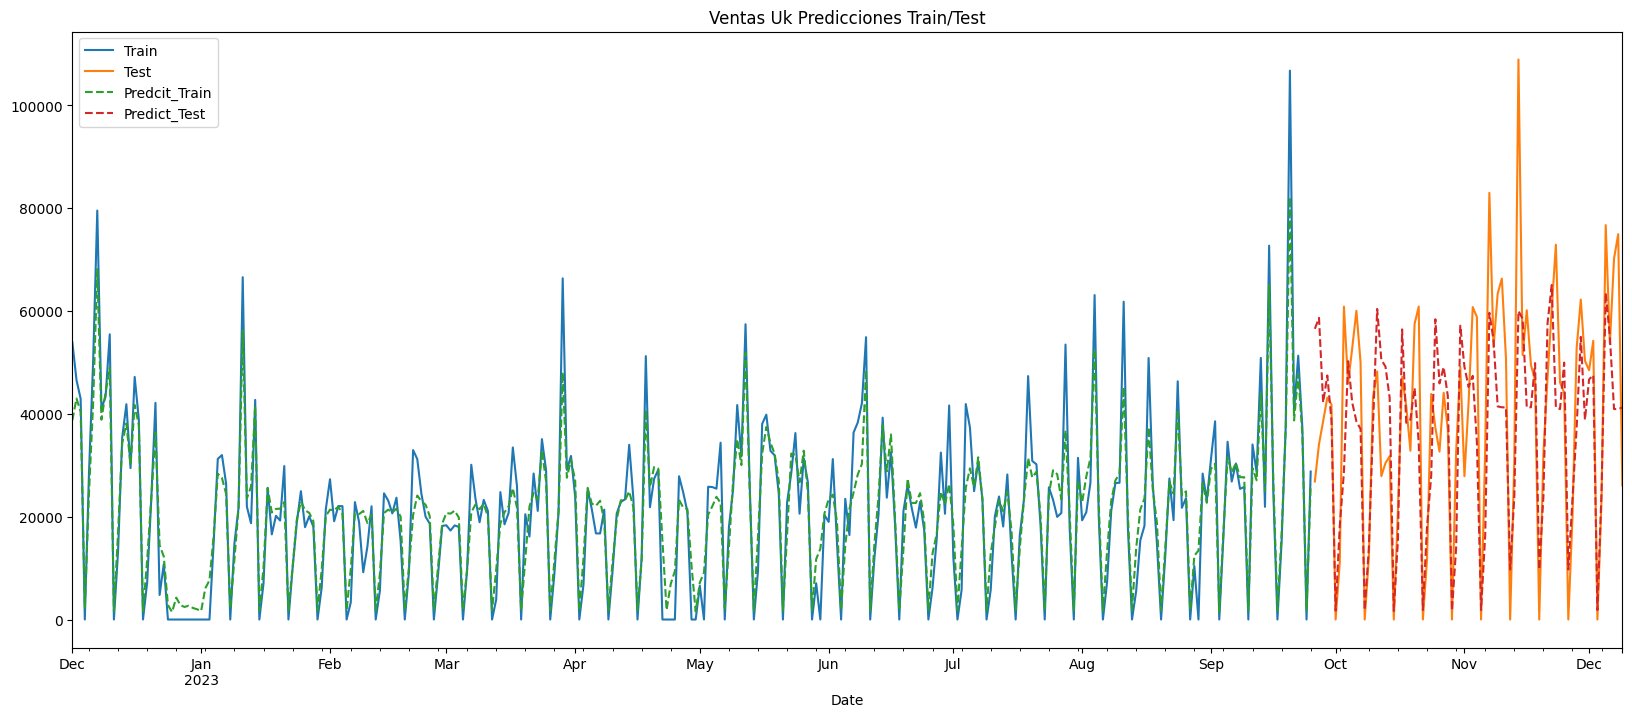

In [191]:
fig, ax = plt.subplots(figsize= (20,8), )
y_train.plot(ax = ax , label = "Train")
y_test.plot(ax = ax , label = "Test")
y_train_pred.plot(ax = ax , label = "Predic_Train", linestyle = "--")
y_test_pred.plot(ax = ax, label = "Predic_Test", linestyle = "--")
ax.legend(["Train", "Test","Predcit_Train","Predict_Test"])
plt.title("Ventas Uk Predicciones Train/Test")
plt.show()

Ahora vamos a emplear el GridSearch para realizar una optimización de hiperparámetros en nuestro modelo.

In [192]:
# Definir los hiperparámetros a buscar
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Crear el modelo base de XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluar el mejor modelo en los conjuntos de entrenamiento y prueba
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

y_train_pred = pd.DataFrame(y_train_pred, columns=['xgb_predictions_train'],index= X_train.index)
y_test_pred = pd.DataFrame(y_test_pred, columns=['xgb_predictions_test'], index= X_test.index)

# Calcular el RMSE y R² para el conjunto de entrenamiento
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

# Calcular el RMSE y R² para el conjunto de prueba
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print(f'Best Params: {best_params}')
print(f'Train RMSE: {rmse_train}')
print(f'Train R²: {r2_train}')
print(f'Test RMSE: {rmse_test}')
print(f'Test R²: {r2_test}')


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}
Train RMSE: 2423.314708584472
Train R²: 0.9777353353175999
Test RMSE: 14792.308703402816
Test R²: 0.5756033824526634


El modelo, tras realizar ajustes con GridSearch, muestra una notable mejora en su desempeño, especialmente en el conjunto de entrenamiento. Sin embargo, todavía existe una diferencia considerable en el rendimiento entre los conjuntos de entrenamiento y prueba. Esto indica que aunque el modelo ha mejorado en términos de ajuste a los datos de entrenamiento, aún presenta signos de sobreajuste (overfitting) y no generaliza tan bien a nuevos datos.

Finalmente, estas son las predicciones finales para el XGBoost

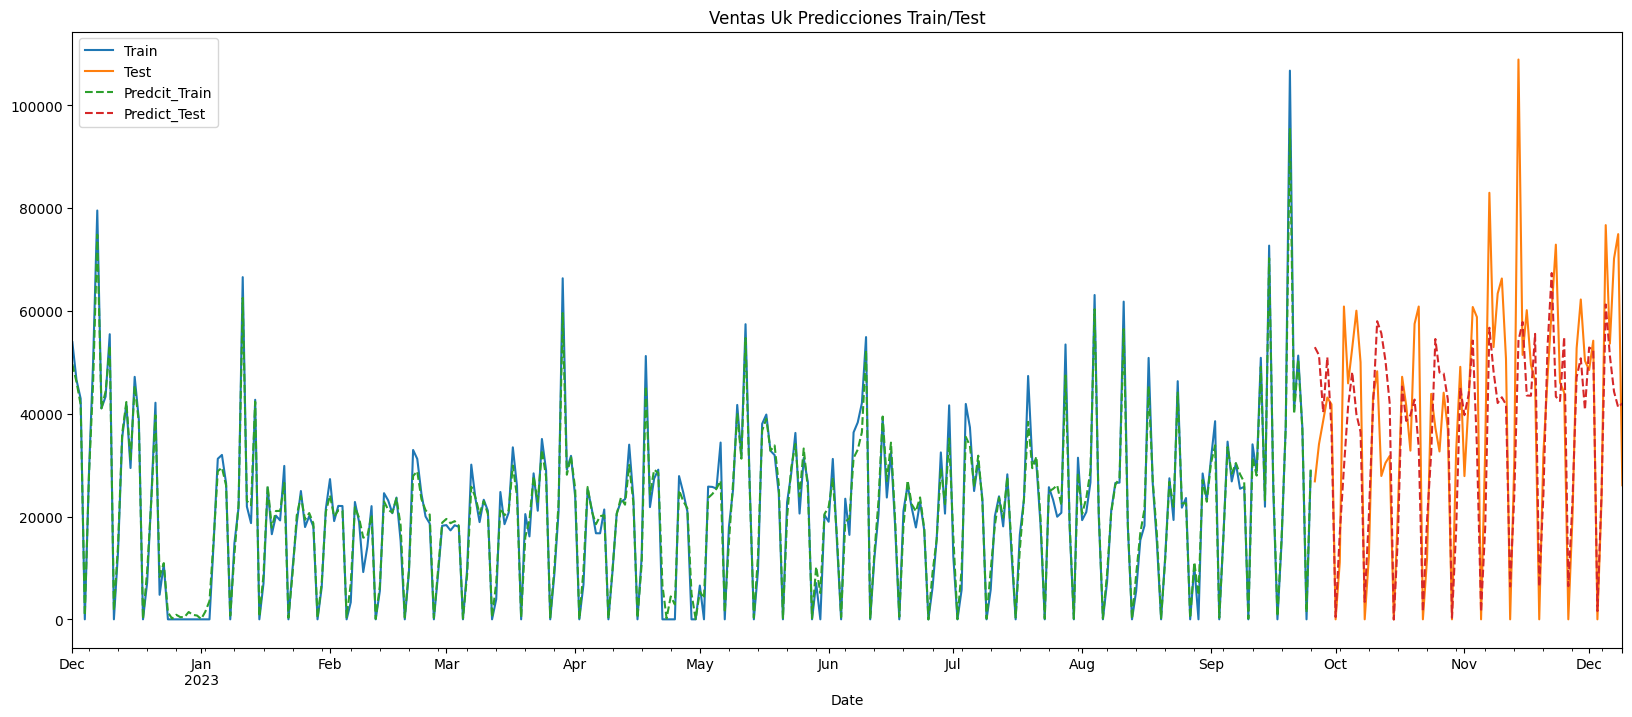

In [193]:
fig, ax = plt.subplots(figsize= (20,8), )
y_train.plot(ax = ax , label = "Train")
y_test.plot(ax = ax , label = "Test")
y_train_pred.plot(ax = ax , label = "Predic_Train", linestyle = "--")
y_test_pred.plot(ax = ax, label = "Predic_Test", linestyle = "--")
ax.legend(["Train", "Test","Predcit_Train","Predict_Test"])
plt.title("Ventas Uk Predicciones Train/Test")
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

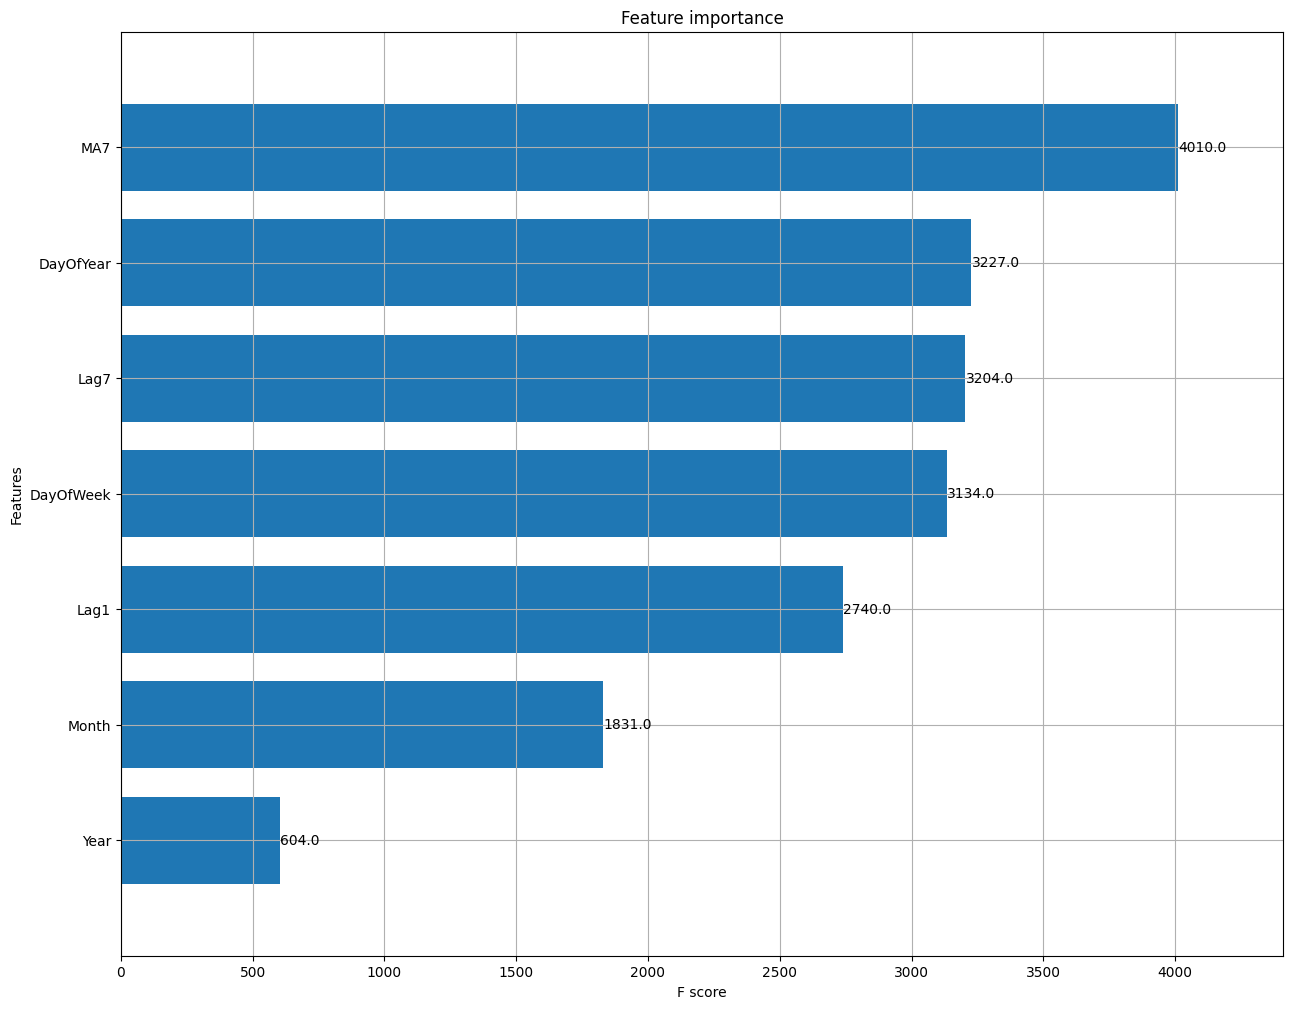

In [194]:
plot_importance(best_model, height = 0.75)

Así queda la importancia de las variables del modelo.

<a id='seccion6'></a>
## 6. Comparación y selección de modelos

Tenemos los siguientes resultados para los distintos modelos:

- SARIMAX
    - RMSE ---------> 13196.34
    - R Cuadrado ---> 0.5329
- Prophet
    - RMSE ---------> 11020.31
    - R Cuadrado ---> 0.674
- XGBoost | Estadísticos sobre fichero Test
    - RMSE ---------> 14792.31
    - R Cuadrado --- 0.5756

El modelo Prophet se destaca como la mejor opción debido a su menor RMSE (11020.31) y mayor R² (0.674), lo que indica mayor precisión y capacidad explicativa en comparación con SARIMAX y XGBoost, siendo por tanto el **Prophet** el modelo más confiable para predecir las ventas diarias en Europa.